## multivariate multi-step encoder-decoder lstm

In [1]:
# multivariate multi-step encoder-decoder lstm
import pandas as pd
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [107]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	scaler = MinMaxScaler(feature_range=(0, 1))
	data = scaler.fit_transform(data)
	train, test = data[0:-50], data[-50:] # 10 days test data,  train data, 5 days per week, in total 495 rows (99 weeks)
	# restructure into windows of weekly data
	train = array(split(train, len(train)/5))
	test = array(split(test, len(test)/5))
	return train, test, scaler

In [4]:
def normalize_data(data):
	# split into standard weeks
	scaler = MinMaxScaler(feature_range=(0, 1))
	data = scaler.fit_transform(data)
	train = data # in total 495 rows (99 weeks)
	# restructure into windows of weekly data
	train = array(split(train, len(train)/5))
	return train, scaler

In [5]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [6]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [7]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=5):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) # data here is training data
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)): # 97 when test = 2 weeks
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :]) # 用 前n_input 周的X和Y variables
			y.append(data[in_end:out_end, 0]) # 来预测 后n_out 周的 Y
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [8]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 1, 200, 30
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(300, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(300, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mae', optimizer='adam')
	###### another model
	#model = Sequential()
	#model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
	#model.add(RepeatVector(n_outputs))
	#model.add(LSTM(100, activation='relu', return_sequences=True))
	#model.add(TimeDistributed(Dense(1)))
	#model.compile(optimizer='adam', loss='mse')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=verbose)
	return model, train_x, train_y

In [9]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	# invert predictions
	temp_a, temp_b, scaler = split_dataset(dataset.values)
	yhat_df = pd.DataFrame(yhat[0])
	input_df = pd.DataFrame(input_x[0])
	transformed = pd.concat([yhat_df, input_df.iloc[:,1:]],axis = 1)
	transformed_all = scaler.inverse_transform(transformed)
	yhat_inversed = transformed_all[:,0]
	return yhat_inversed, input_x

In [10]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model, train_x, train_y = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence, input_x = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions, history, train_x, train_y, input_x

In [35]:
# load the new file
dataset = read_csv('/Users/kexinliang/Desktop/Competition/new_weather/final/3contrat.csv', infer_datetime_format=True, index_col=['Time'])

In [108]:
# split into train and test
train, test, useless = split_dataset(dataset.values)

In [109]:
dataset.shape

(495, 11)

In [110]:
train.shape # 97 weeks, 97*5 days

(89, 5, 11)

In [111]:
test.shape # 2 weeks, 10 days

(10, 5, 11)

In [112]:
# evaluate model and get scores
n_input = 10
score, scores, predictions, history, train_x, train_y, input_x = evaluate_model(train, test, n_input)

Epoch 1/200
431/431 [==============================] - 1s 3ms/step - loss: 0.3275
Epoch 2/200
 90/431 [=====>........................] - ETA: 0s - loss: 0.1596

/Users/kexinliang/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


431/431 [==============================] - 1s 2ms/step - loss: 0.1342
Epoch 3/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0886
Epoch 4/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0745
Epoch 5/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0747
Epoch 6/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0719
Epoch 7/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0688
Epoch 8/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0691
Epoch 9/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0603
Epoch 10/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0612
Epoch 11/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0599
Epoch 12/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0551
Epoch 13/200
431/431 [==============================] - 1s 2ms/step - loss: 0.0520
Epoch 14/200
431/431 [==

In [41]:
##### forecast
n_input = 10
train, scaler = normalize_data(dataset)
model, train_x, train_y = build_model(train, n_input)

Epoch 1/10
481/481 [==============================] - 1s 3ms/step - loss: 0.2893
Epoch 2/10
 90/481 [====>.........................] - ETA: 0s - loss: 0.1491

/Users/kexinliang/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


481/481 [==============================] - 1s 2ms/step - loss: 0.1167
Epoch 3/10
481/481 [==============================] - 1s 2ms/step - loss: 0.1346
Epoch 4/10
481/481 [==============================] - 1s 2ms/step - loss: 0.0904
Epoch 5/10
481/481 [==============================] - 1s 2ms/step - loss: 0.0737
Epoch 6/10
481/481 [==============================] - 1s 2ms/step - loss: 0.0740
Epoch 7/10
481/481 [==============================] - 1s 2ms/step - loss: 0.0725
Epoch 8/10
481/481 [==============================] - 1s 2ms/step - loss: 0.0751
Epoch 9/10
481/481 [==============================] - 1s 2ms/step - loss: 0.0705
Epoch 10/10
481/481 [==============================] - 1s 2ms/step - loss: 0.0648


In [613]:
###### forecast
history = [x for x in train]
temp_yhat = forecast(model, history, n_input)

In [614]:
temp_yhat

array([969.2165333 , 969.6918093 , 969.73878059, 969.77543044,
       970.05525513,          nan,          nan,          nan,
                nan,          nan])

In [310]:
#temp_yhat = pd.DataFrame(temp_yhat[0])
#temp_yhat
956.66081563, 962.33585468, 961.76664117,  959.72347155, 957.34300163

In [311]:
#temp_input[0]

In [312]:
#temp_input_df = pd.DataFrame(temp_input[0])
#temp_input_df.iloc[:,1:]
#transformed = pd.concat([temp_yhat, temp_input_df],axis = 1)
#transformed.values

In [52]:
print(len(history))
print(len(history[0]))

99
5


In [57]:
input_x.shape

(1, 5, 12)

In [53]:
train_x.shape

(476, 5, 12)

In [54]:
train_y.shape

(476, 5, 1)

In [55]:
predictions

array([[964.22325762, 966.87172119, 965.9349632 , 965.5289458 ,
        965.31258047],
       [965.39182812, 968.02710125, 967.09783067, 966.66671818,
        966.48333772]])

In [70]:
# summarize scores
summarize_scores('lstm', score, scores) # last time 913, 961-

lstm: [923.606] 923.5, 924.3, 923.9, 923.4, 922.9


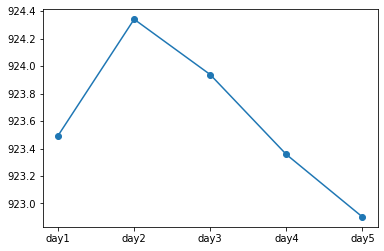

In [71]:
# plot scores
days = ['day1', 'day2', 'day3', 'day4', 'day5']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [72]:
print(predictions)

[[900.46378434 904.53773953 906.50206135 907.68463871 908.50058007
           nan          nan          nan          nan          nan]
 [896.83529368 898.63213493 898.7296382  898.4456764  898.07227322
           nan          nan          nan          nan          nan]
 [907.86877733 907.36625379 905.93087929 904.524956   903.38124904
           nan          nan          nan          nan          nan]
 [938.36304441 938.45387676 937.73531353 937.14123568 936.83528775
           nan          nan          nan          nan          nan]
 [952.87042275 952.43566731 950.83497331 949.2986975  948.18032175
           nan          nan          nan          nan          nan]
 [946.26212844 946.54506025 945.83468887 945.04666334 944.49866587
           nan          nan          nan          nan          nan]]


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
predictions.reshape(1,60)[0][0:5]

array([900.46378434, 904.53773953, 906.50206135, 907.68463871,
       908.50058007])

In [93]:
predictions.reshape(-1,1)[0:5]

array([[900.46378434],
       [904.53773953],
       [906.50206135],
       [907.68463871],
       [908.50058007]])

In [105]:
predictions.reshape(1,60)[0][50:55]

array([946.26212844, 946.54506025, 945.83468887, 945.04666334,
       944.49866587])

In [102]:
predictions.reshape(-1,1)[10:15]

896.8352936804295

ValueError: cannot reshape array of size 60 into shape (0,1)

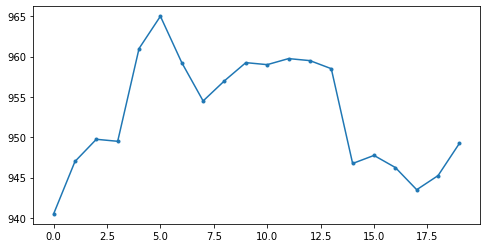

In [100]:
aa=[x for x in range(20)]
plt.figure(figsize=(8,4))
plt.plot(aa, dataset['Close'].tail(20).values, marker='.', label="actual")
plt.plot(aa, array(predictions).reshape(0,1), 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

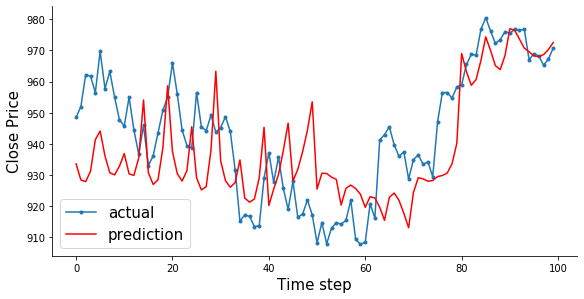

In [72]:
aa=[x for x in range(100)]
plt.figure(figsize=(8,4))
plt.plot(aa, dataset['Close'].tail(100).values, marker='.', label="actual")
plt.plot(aa, array(predictions).reshape(1,-1)[0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Close Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [462]:
train_x.shape

(476, 5, 21)

In [627]:
array(predictions).reshape(1,-1)[0]

array([975.37830077, 972.51556239, 969.4270644 , 966.54663087,
       964.20010436, 968.2076477 , 968.24049261, 968.04997461,
       968.29251966, 969.39762206])

In [464]:
train_y.shape

(476, 5, 1)

In [44]:
l = []
for i in predictions:
    for j in i:
        l.append(j)

In [46]:
actual = dataset['Close'].tail(20).values
actual

array([940.5 , 947.  , 949.75, 949.5 , 961.  , 965.  , 959.25, 954.5 ,
       957.  , 959.25, 959.  , 959.75, 959.5 , 958.5 , 946.75, 947.75,
       946.25, 943.5 , 945.25, 949.25])

In [47]:
l-actual

array([ 5.9657504 ,  6.39910054,  9.48317322, 13.67906693,  5.82292092,
       -7.37821543,  3.87020302, 14.9960258 , 17.97796428, 19.0816091 ,
       -5.43170062, -1.68184122,  4.05360118, 10.2904675 , 25.62102956,
        5.92947179, 13.36700633, 22.51599926, 25.91693294, 25.22096458])

In [48]:
mean_absolute_error(l,actual) # last time 16.136207627505065

12.234152230620385